# 1. Importing Libraries

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# 2. Loading the datasets

In [114]:
customer_path = '/content/Mall_Customers.csv'
wine_path = '/content/wine-clustering.csv'

customer_data = pd.read_csv(customer_path)
wine_data = pd.read_csv(wine_path)

In [115]:
# Inspect the Wine dataset
wine_data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [116]:
# Inspect the Customer dataset
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# 3. Data Preprocessing

In [117]:
def preprocess_data(dataset, categorical_columns=None):
    data = dataset.copy()

    # Handle missing values
    data = data.dropna()  # Drop rows with missing values (alternative: imputation)

    # Encode categorical columns
    if categorical_columns:
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            data[col] = label_encoder.fit_transform(data[col])

    # Normalize or scale numerical features
    numeric_cols = data.select_dtypes(include=["number"]).columns
    scaler = StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

    return data

Preprocess Wine_Clustering dataset

In [118]:
wine_data_preprocessed = preprocess_data(wine_data)

Preprocess Mall_Customers dataset

In [119]:
customer_data = customer_data.drop('CustomerID', axis=1)
customer_data_preprocessed = preprocess_data(customer_data, categorical_columns=["Gender"])

# 4. Data Visualization

## Step 1: Exploratory Data Analysis (EDA)

In [120]:
def perform_eda(dataset, name):
    print(f"Dataset: {name}")
    print(dataset.info())
    print(dataset.describe())
    print(f"Missing Values:\n{dataset.isnull().sum()}")
    print(f"Sample Data:\n{dataset.head()}\n")

    # Correlation heatmap for numeric features
    numeric_data = dataset.select_dtypes(include=["number"])
    if not numeric_data.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
        plt.title(f'{name} - Correlation Heatmap')
        plt.show()

Perform EDA after preprocessing

Dataset: Wine Dataset (Preprocessed)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    float64
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    float64
dtypes: float64(13)
memory usage: 18.2 KB
None
            Alcohol    Malic_Acid           As

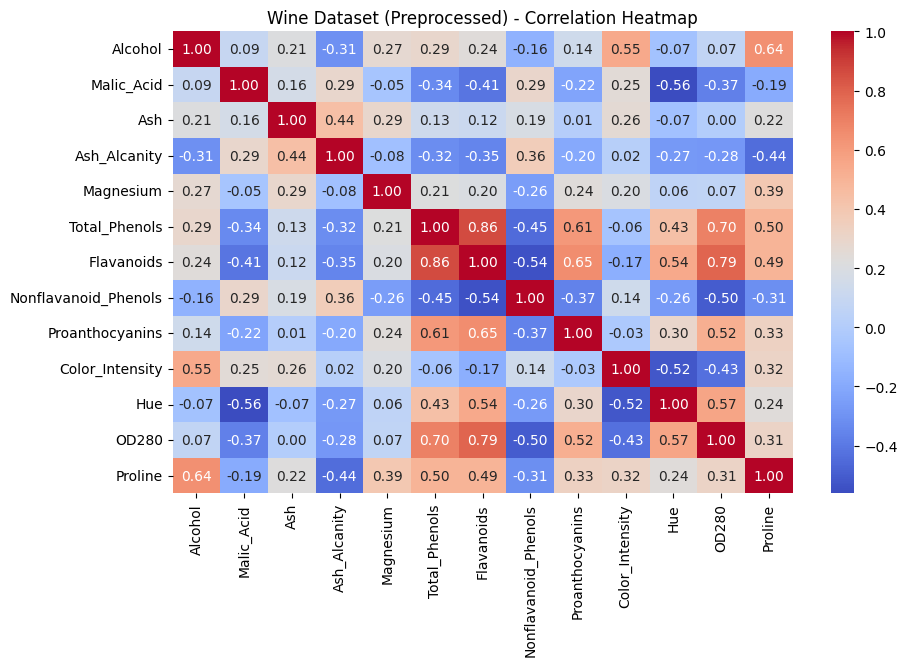

In [121]:
perform_eda(wine_data_preprocessed, "Wine Dataset (Preprocessed)")

Dataset: Customer Dataset (Preprocessed)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  200 non-null    float64
 1   Age                     200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Spending Score (1-100)  200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB
None
             Gender           Age  Annual Income (k$)  Spending Score (1-100)
count  2.000000e+02  2.000000e+02        2.000000e+02            2.000000e+02
mean   3.108624e-17 -1.021405e-16       -2.131628e-16           -1.465494e-16
std    1.002509e+00  1.002509e+00        1.002509e+00            1.002509e+00
min   -8.864053e-01 -1.496335e+00       -1.738999e+00           -1.910021e+00
25%   -8.864053e-01 -7.248436e-01       -7.275093e-01           -5.997931e-01
50%   -8.864053e-01 -2.0

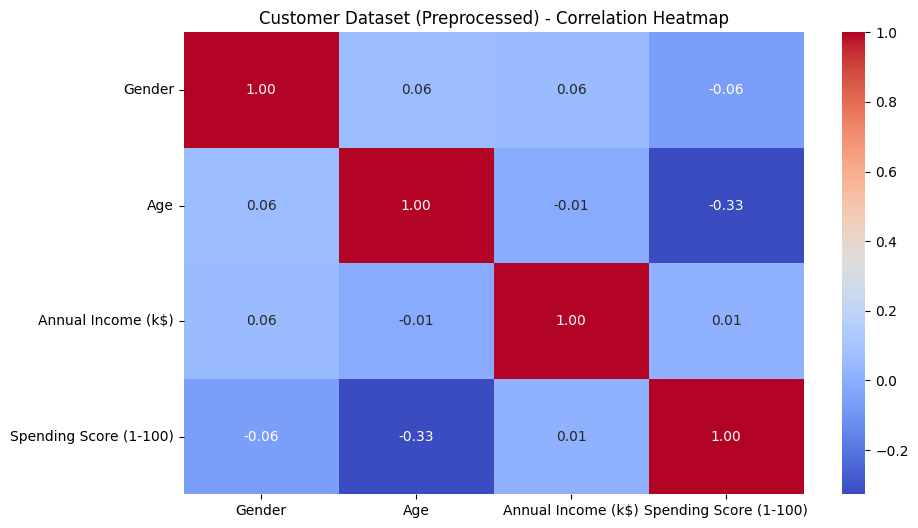

In [122]:
perform_eda(customer_data_preprocessed, "Customer Dataset (Preprocessed)")

## Step 2: Dimensionality Reduction and Visualization

In [123]:
def visualize_data(dataset, name, features=None):
    if features:
        data = dataset[features].dropna()
    else:
        data = dataset.select_dtypes(include=["number"]).dropna()

    # PCA - 2D
    pca = PCA(n_components=2)
    pca_2d = pca.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_2d[:, 0], pca_2d[:, 1], alpha=0.7, edgecolor='k')
    plt.title(f'{name} - PCA Reduced to 2D')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

    # PCA - 3D
    if data.shape[1] > 2:
        pca_3d = PCA(n_components=3).fit_transform(data)
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_3d[:, 0], pca_3d[:, 1], pca_3d[:, 2], alpha=0.7)
        ax.set_title(f'{name} - PCA Reduced to 3D')
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        plt.show()

    # t-SNE - 2D
    tsne = TSNE(n_components=2, random_state=42)
    tsne_2d = tsne.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], alpha=0.7, edgecolor='k')
    plt.title(f'{name} - t-SNE Reduced to 2D')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

Visualize Wine_Clustering dataset

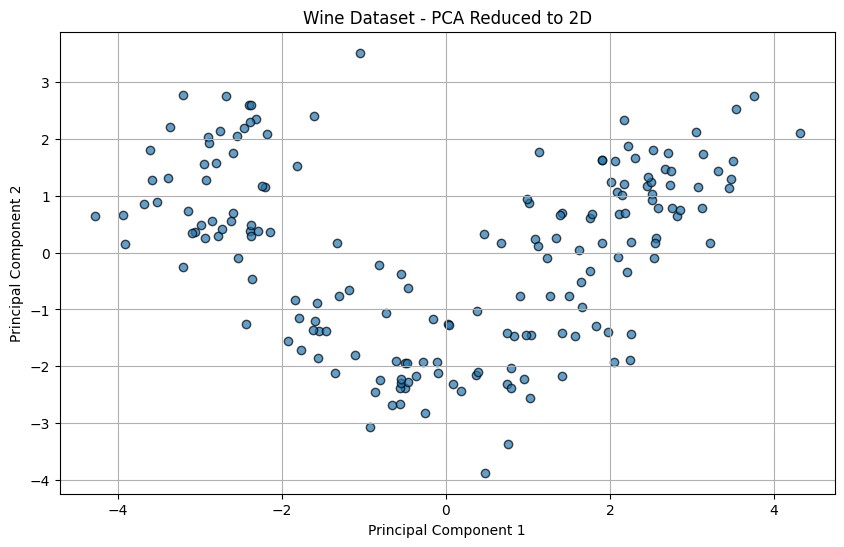

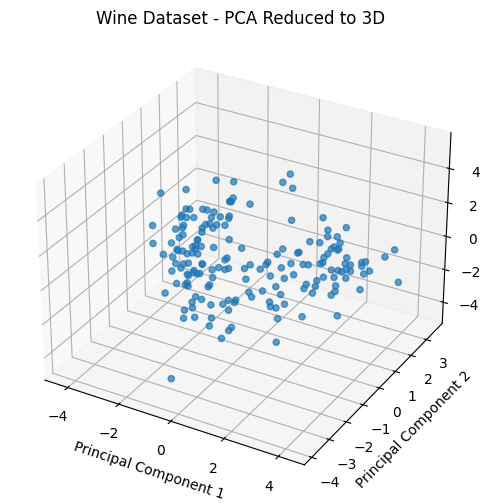

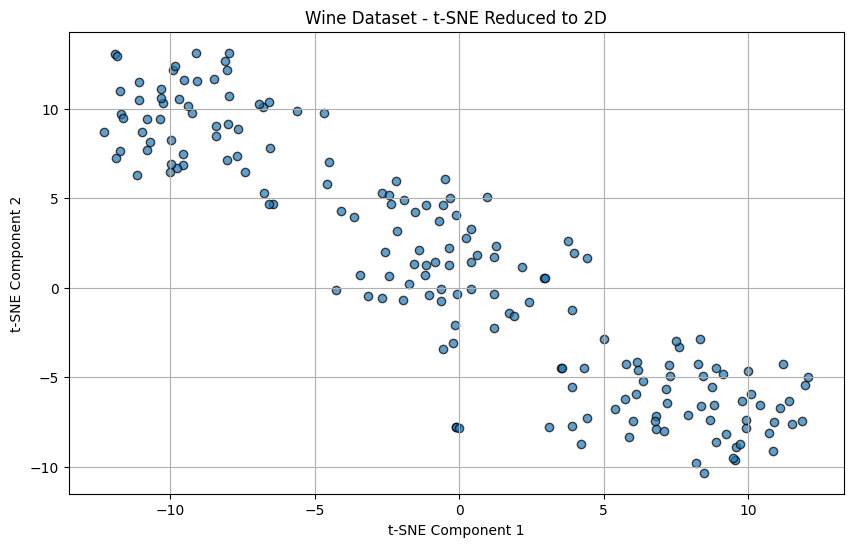

In [124]:
visualize_data(wine_data_preprocessed, "Wine Dataset")

Visualize Mall_Customers dataset

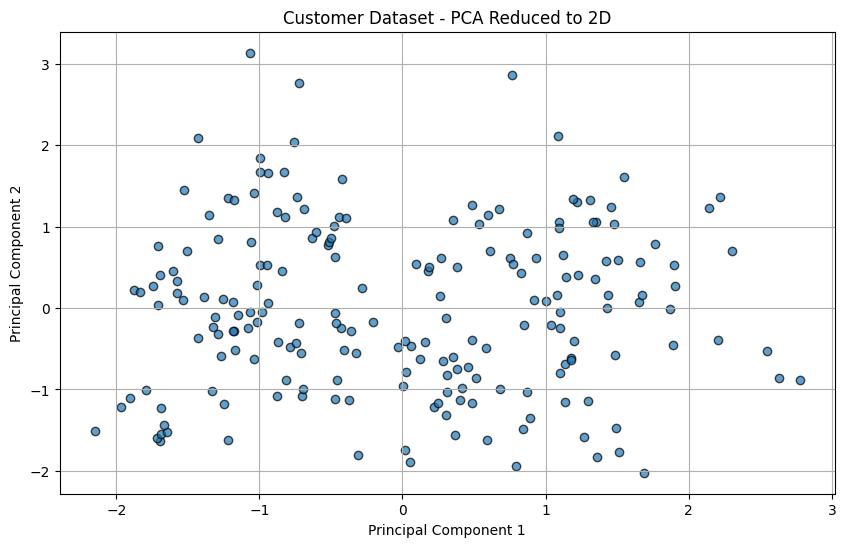

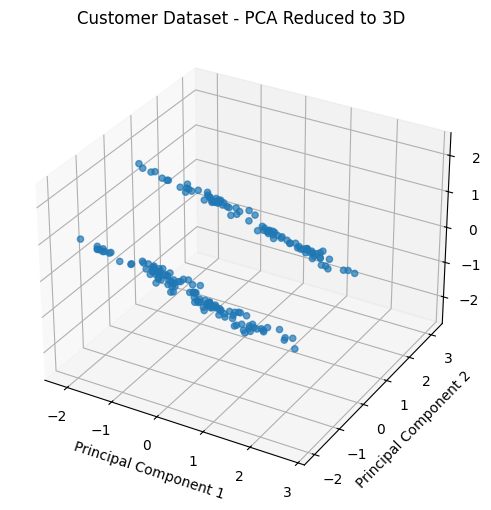

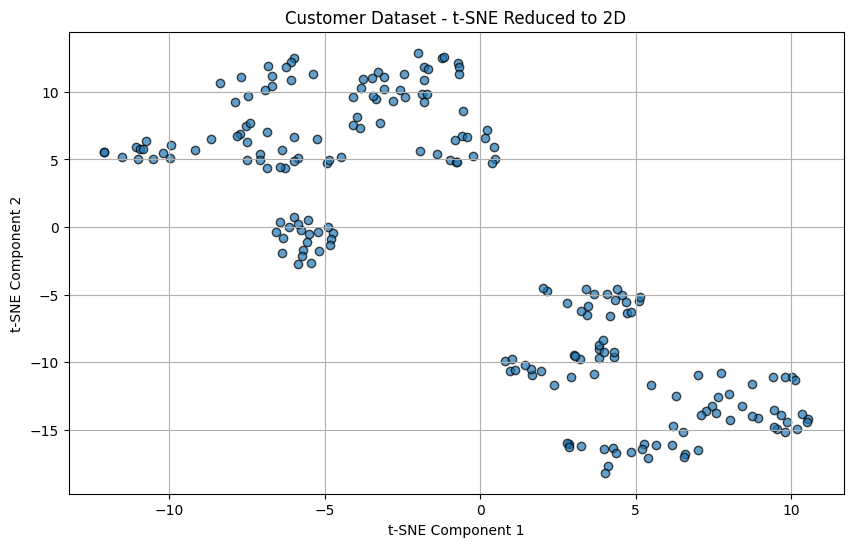

In [125]:
visualize_data(customer_data_preprocessed, "Customer Dataset")

# 5. Utilites

## Function to visualize clusters with tsne

In [126]:
def visualize_clusters_with_tsne(data, labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    plt.figure(figsize=(10, 6))
    for cluster_id in np.unique(labels):
        cluster_points = tsne_data[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', alpha=0.7)

    plt.title(f'{dataset_name} - Clustering Results (t-SNE Visualization)')
    plt.legend()
    plt.grid(True)
    plt.show()

## Function to calculate intra-cluster distances

In [127]:
def calculate_intra_cluster_distance(data, labels):
    clusters = np.unique(labels)

    # Calculate cluster centers
    cluster_centers = np.array([data[labels == k].mean(axis=0) for k in clusters])

    # Intra-cluster distance
    intra_distances = []
    for k in clusters:
        cluster_points = data[labels == k]
        distances = cdist(cluster_points, [cluster_centers[k]])
        intra_distances.append(distances.mean())
    avg_intra_cluster_distance = np.mean(intra_distances)

    return avg_intra_cluster_distance

## Function to calculate inter-cluster distances

In [128]:
def calculate_inter_cluster_distance(data, labels):
    clusters = np.unique(labels)

    # Calculate cluster centers
    cluster_centers = np.array([data[labels == k].mean(axis=0) for k in clusters])

    # Inter-cluster distance
    inter_distances = cdist(cluster_centers, cluster_centers)
    inter_distances = inter_distances[inter_distances > 0]  # Remove zero distance (same cluster)
    avg_inter_cluster_distance = inter_distances.mean()

    return avg_inter_cluster_distance

# 6. Hierarchical and Agglomerative Clustering

Standardize both datasets

In [129]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_preprocessed)
wine_data_scaled = scaler.fit_transform(wine_data_preprocessed)

## 6.1. With libraries

### 6.1.1. Wine dataset

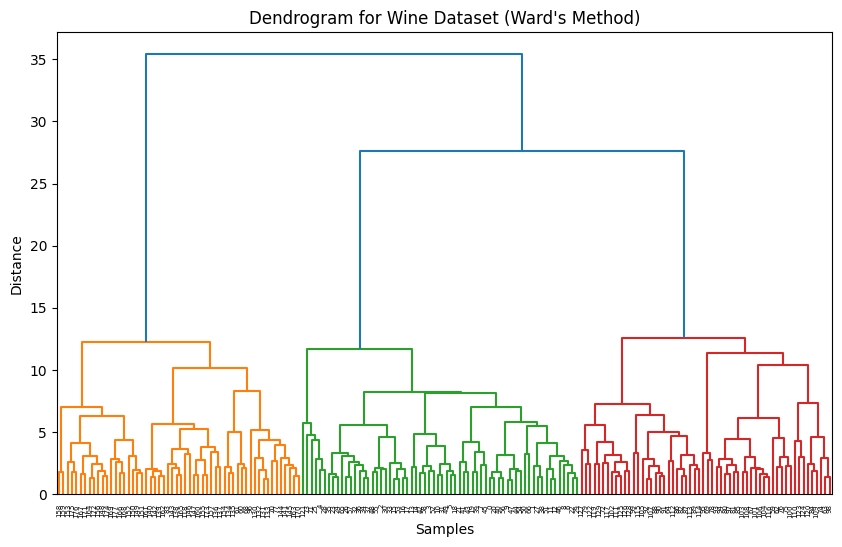

In [130]:
linkage_matrix_wine = linkage(wine_data_scaled, method='ward')

# Plot dendrogram for Wine dataset
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_wine)
plt.title("Dendrogram for Wine Dataset (Ward's Method)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

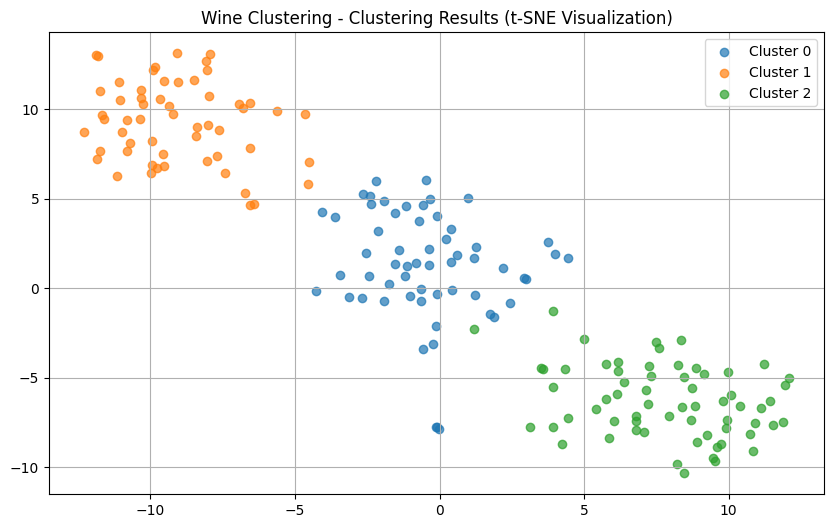

In [131]:
start_time = time.time()  # Start time

# Wine dataset: 3 clusters
agg_clustering_wine = AgglomerativeClustering(n_clusters=3, linkage='ward')
wine_labels = agg_clustering_wine.fit_predict(wine_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(wine_data_scaled, wine_labels, "Wine Clustering")

In [132]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 0.0075 seconds
Wine Dataset - Average Intra-cluster Distance: 2.5619128220711183
Wine Dataset - Average Inter-cluster Distance: 4.087959055360146


### 6.1.2. Customer dataset

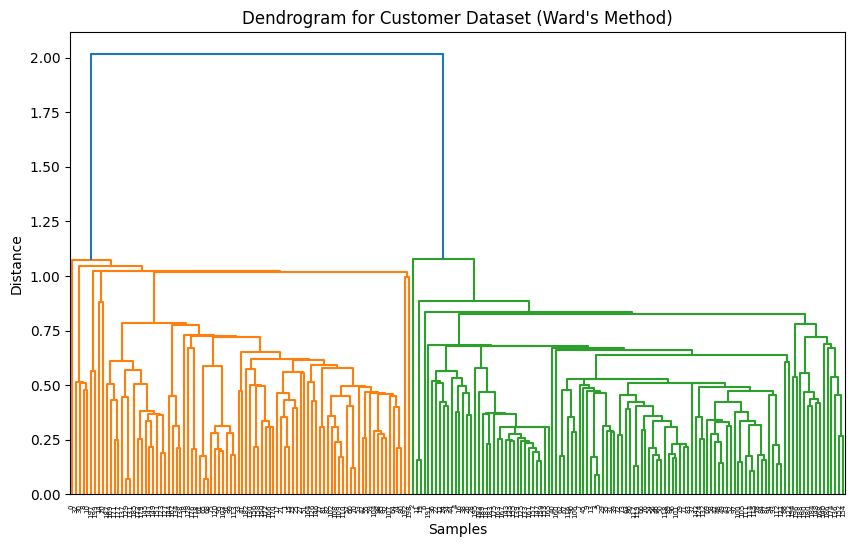

In [133]:
linkage_matrix_customer = linkage(customer_data_scaled, method='single')

# Plot dendrogram for Wine dataset
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_customer)
plt.title("Dendrogram for Customer Dataset (Ward's Method)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

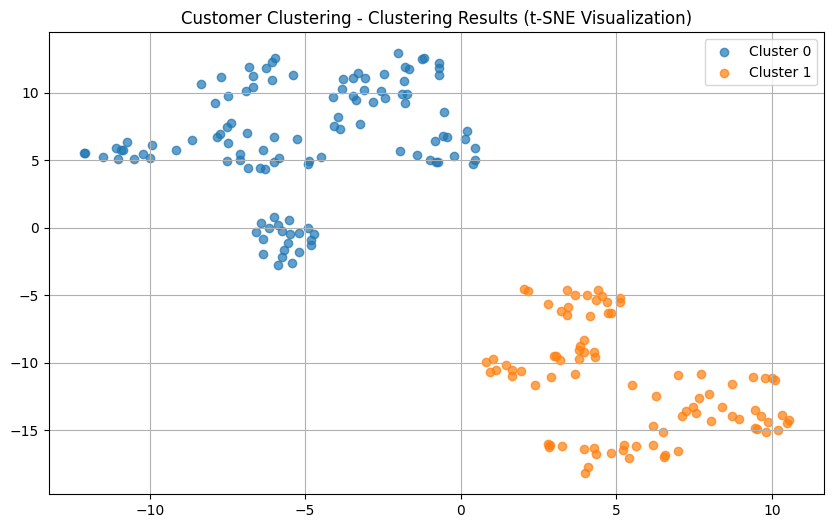

In [134]:
start_time = time.time()  # Start time

# Customer dataset: 2 clusters
agg_clustering_customer = AgglomerativeClustering(n_clusters=2, linkage='single')
customer_labels = agg_clustering_customer.fit_predict(customer_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(customer_data_scaled, customer_labels, "Customer Clustering")

In [135]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 0.0027 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6317346696989905
Customer Dataset - Average Inter-cluster Distance: 2.0248692548719602


## 6.2. Manually

### Functions


Calculate the distance matrix

In [136]:
def calculate_distance_matrix(data):
    n = len(data)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist_matrix[i, j] = np.linalg.norm(data[i] - data[j])
            dist_matrix[j, i] = dist_matrix[i, j]
    return dist_matrix

Manual Hierarchical Clustering Implementation

In [137]:
def hierarchical_clustering(data, method='ward'):
    n = len(data)
    clusters = {i: [i] for i in range(n)}  # Start with each point as its own cluster
    distance_matrix = calculate_distance_matrix(data)
    cluster_history = []

    while len(clusters) > 1:
        # Find the two closest clusters
        min_dist = float('inf')
        merge = (-1, -1)
        cluster_keys = list(clusters.keys())

        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                ci, cj = cluster_keys[i], cluster_keys[j]
                if method == "single":
                    # Calculate single linkage distance
                    dist = np.min([distance_matrix[p1, p2] for p1 in clusters[ci] for p2 in clusters[cj]])
                elif method == "complete":
                    # Calculate complete linkage distance
                    dist = np.max([distance_matrix[p1, p2] for p1 in clusters[ci] for p2 in clusters[cj]])
                elif method == "average":
                    # Calculate average linkage distance
                    dist = np.mean([distance_matrix[p1, p2] for p1 in clusters[ci] for p2 in clusters[cj]])
                elif method == "ward":
                    # Calculate ward linkage distance
                    ci_size = len(clusters[ci])
                    cj_size = len(clusters[cj])
                    ci_center = np.mean([data[i] for i in clusters[ci]], axis=0)
                    cj_center = np.mean([data[i] for i in clusters[cj]], axis=0)
                    dist = (ci_size * cj_size) / (ci_size + cj_size) * np.sum((ci_center - cj_center) ** 2)
                if dist < min_dist:
                    min_dist = dist
                    merge = (ci, cj)

        # Merge the closest clusters
        ci, cj = merge
        clusters[ci] += clusters[cj]
        del clusters[cj]

        # Update the history for dendrogram
        cluster_history.append((ci, cj, min_dist, len(clusters[ci])))

    return cluster_history

Build Dendrogram


In [138]:
def plot_dendrogram(cluster_history, data, dataset_name):
    plt.figure(figsize=(12, 8))  # Adjust figure size for readability
    current_idx = len(data)
    for ci, cj, dist, size in cluster_history:
        plt.plot([ci, ci, cj, cj], [0, dist, dist, 0], color='black', lw=0.8)  # Thinner lines for clarity

    plt.title(f"Dendrogram for {dataset_name}")
    plt.xlabel("Points (Cluster Index)")
    plt.ylabel("Distance")
    plt.xticks(fontsize=8, rotation=90)  # Rotate x-axis labels for better visibility
    plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid
    plt.show()

Manual Agglomerative Clustering Implementation

In [139]:
def agglomerative_clustering(data, num_clusters, method='ward'):
    n = len(data)
    clusters = {i: [i] for i in range(n)}
    dist_matrix = calculate_distance_matrix(data)

    while len(clusters) > num_clusters:
        # Find the two closest clusters
        min_dist = float('inf')
        merge_pair = (-1, -1)
        for c1 in clusters:
            for c2 in clusters:
                if c1 != c2:
                    if method == "single":
                        # Calculate single linkage distance
                        dist = np.min([dist_matrix[p1, p2] for p1 in clusters[c1] for p2 in clusters[c2]])
                    elif method == "complete":
                        # Calculate complete linkage distance
                        dist = np.max([dist_matrix[p1, p2] for p1 in clusters[c1] for p2 in clusters[c2]])
                    elif method == "average":
                        # Calculate average linkage distance
                        dist = np.mean([dist_matrix[p1, p2] for p1 in clusters[c1] for p2 in clusters[c2]])
                    elif method == "ward":
                        c1_size = len(clusters[c1])
                        c2_size = len(clusters[c2])
                        c1_center = np.mean([data[i] for i in clusters[c1]], axis=0)
                        c2_center = np.mean([data[i] for i in clusters[c2]], axis=0)
                        dist = (c1_size * c2_size) / (c1_size + c2_size) * np.sum((c1_center - c2_center) ** 2)
                    if dist < min_dist:
                        min_dist = dist
                        merge_pair = (c1, c2)

        # Merge the clusters
        c1, c2 = merge_pair
        clusters[c1].extend(clusters[c2])
        del clusters[c2]

    # Assign cluster labels
    labels = np.zeros(n, dtype=int)
    for cluster_id, points in enumerate(clusters.values()):
        for point in points:
            labels[point] = cluster_id

    return labels

Visualize Clusters with t-SNE

In [140]:
def visualize_clusters_with_tsne(data, labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    plt.figure(figsize=(10, 6))
    for cluster_id in np.unique(labels):
        cluster_points = tsne_data[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', alpha=0.7)

    plt.title(f'{dataset_name} - Clustering Results (t-SNE Visualization)')
    plt.legend()
    plt.grid(True)
    plt.show()

### 6.2.1. Wine dataset

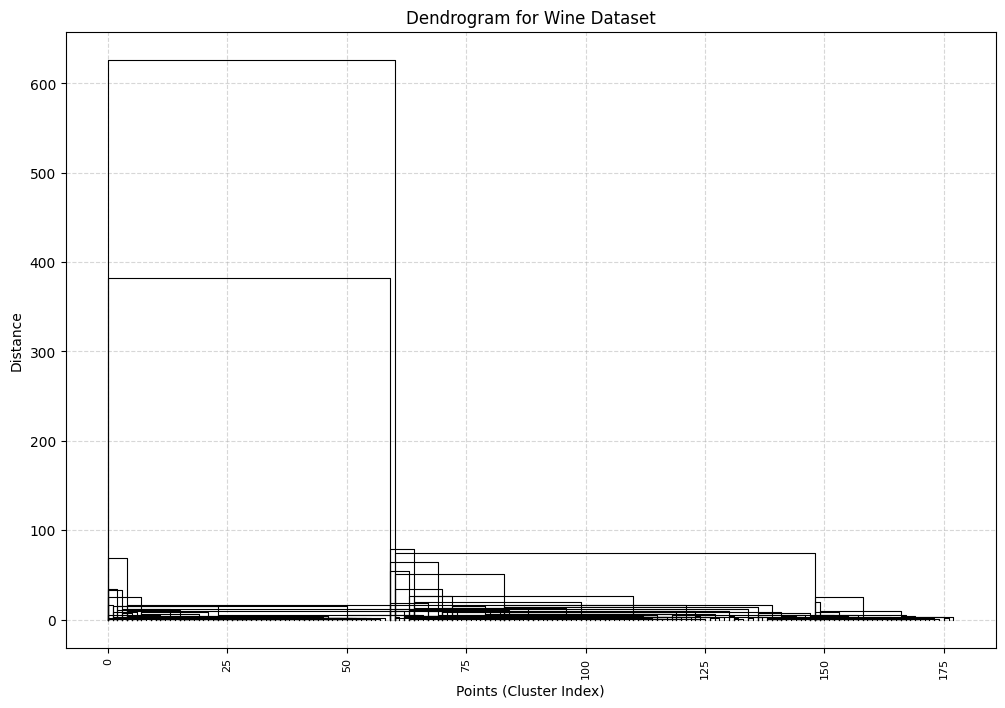

In [141]:
wine_cluster_history = hierarchical_clustering(wine_data_scaled, method='ward')
plot_dendrogram(wine_cluster_history, wine_data_scaled, "Wine Dataset")

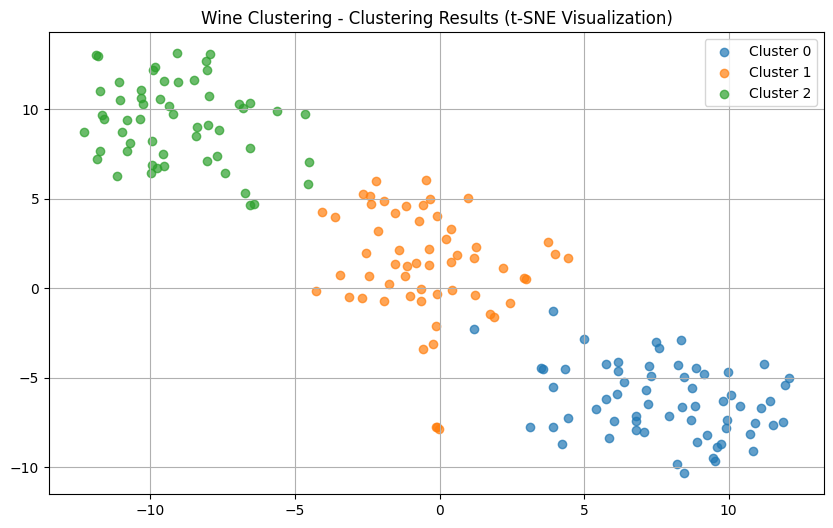

In [142]:
start_time = time.time()  # Start time

wine_labels = agglomerative_clustering(wine_data_scaled, num_clusters=3, method='ward')

end_time = time.time()  # End time

visualize_clusters_with_tsne(wine_data_scaled, wine_labels, "Wine Clustering")

In [143]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 100.6263 seconds
Wine Dataset - Average Intra-cluster Distance: 2.5619128220711183
Wine Dataset - Average Inter-cluster Distance: 4.0879590553601455


### 6.2.2. Customer dataset

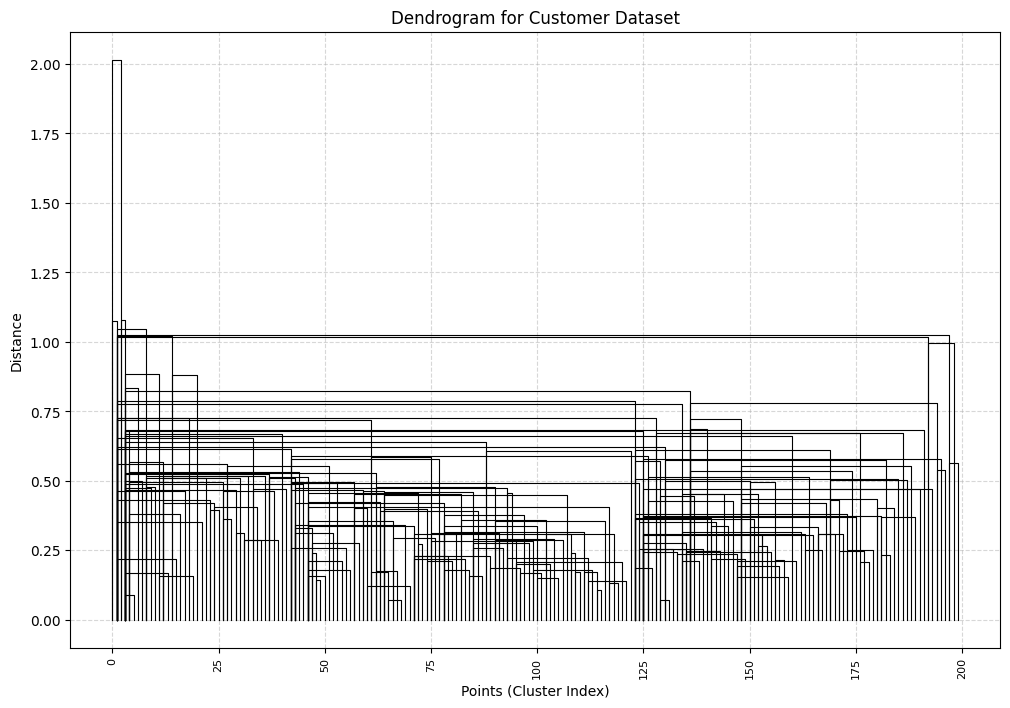

In [144]:
customer_cluster_history = hierarchical_clustering(customer_data_scaled, method='single')
plot_dendrogram(customer_cluster_history, customer_data_scaled, "Customer Dataset")

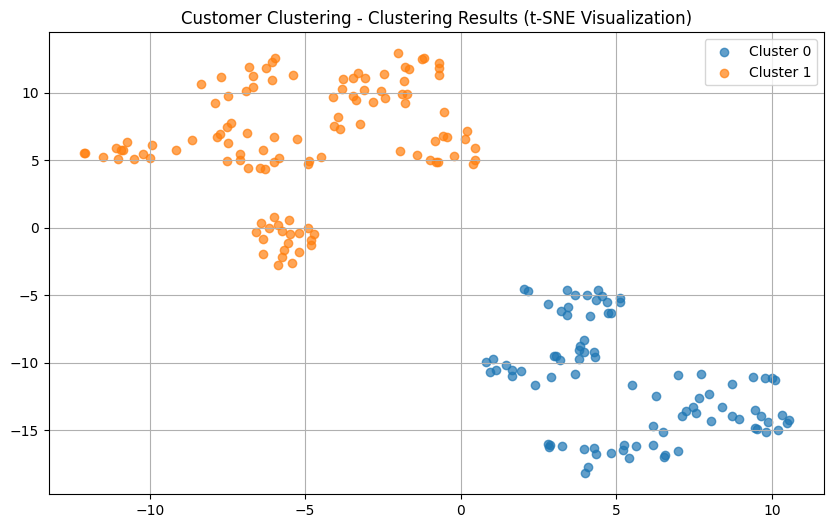

In [145]:
start_time = time.time()  # Start time

customer_labels = agglomerative_clustering(customer_data_scaled, num_clusters=2, method='single')

end_time = time.time()  # End time

visualize_clusters_with_tsne(customer_data_scaled, customer_labels, "Customer Clustering")

In [146]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 21.9066 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6317346696989905
Customer Dataset - Average Inter-cluster Distance: 2.0248692548719602


# 7. EM Clustering

Standardize both datasets

In [147]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_preprocessed)
wine_data_scaled = scaler.fit_transform(wine_data_preprocessed)

## 7.1. With libraries

### 7.1.1. Wine dataset

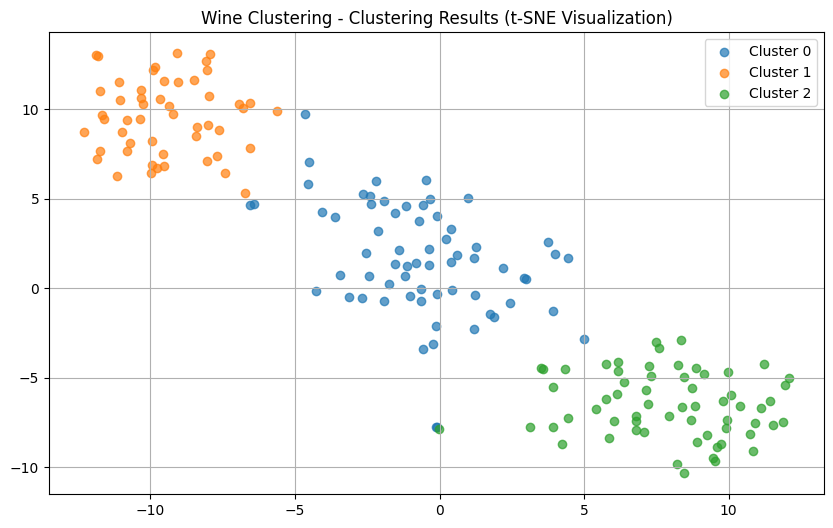

In [148]:
start_time = time.time()  # Start time

wine_gmm = GaussianMixture(n_components=3, random_state=42)
wine_labels = wine_gmm.fit_predict(wine_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(wine_data_scaled, wine_labels, "Wine Clustering")

In [149]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 0.0110 seconds
Wine Dataset - Average Intra-cluster Distance: 2.5234201274965593
Wine Dataset - Average Inter-cluster Distance: 4.199476358573155


### 7.1.2. Customer dataset

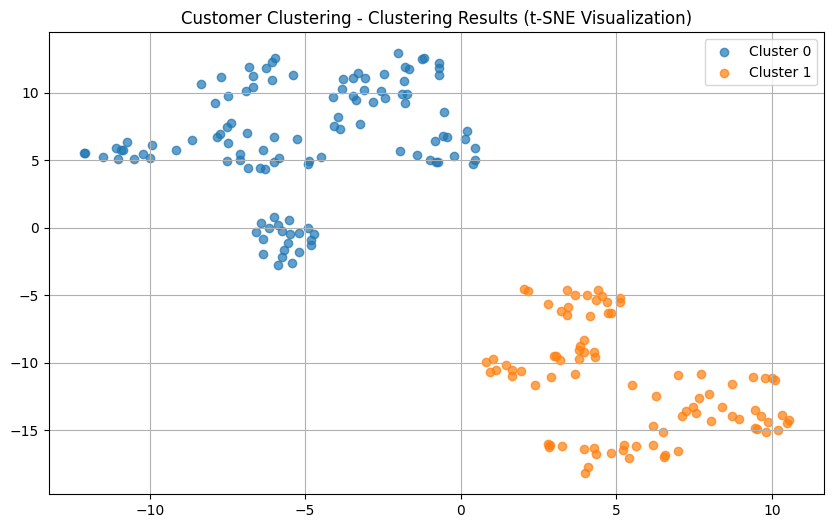

In [150]:
start_time = time.time()  # Start time

customer_gmm = GaussianMixture(n_components=2, random_state=42)
customer_labels = customer_gmm.fit_predict(customer_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(customer_data_scaled, customer_labels, "Customer Clustering")

In [151]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 0.0121 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6317346696989905
Customer Dataset - Average Inter-cluster Distance: 2.0248692548719602


## 7.2. Manually

### Functions


Helper function: Multivariate Gaussian PDF


In [152]:
def multivariate_gaussian(x, mean, cov):
    n = len(mean)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / ((2 * np.pi) ** (n / 2) * (det_cov ** 0.5))
    x_diff = x - mean
    exp_term = np.exp(-0.5 * np.dot(np.dot(x_diff.T, inv_cov), x_diff))
    return norm_const * exp_term

In [153]:
from sklearn.cluster import KMeans

def initialize_means_with_kmeans(data, n_components):

    kmeans = KMeans(n_clusters=n_components, random_state=0).fit(data)

    return kmeans.cluster_centers_

Expectation-Maximization Algorithm

In [154]:
def expectation_maximization(data, k, max_iters=100, tol=1e-6, random_state=42):
    n, d = data.shape

    # Step 1: Initialize parameters
    np.random.seed(random_state)

    means = initialize_means_with_kmeans(data, k)  # Randomly choose k points as initial means
    # means = data[np.random.choice(n, k, replace=False)]  # Randomly choose k points as initial means
    covariances = np.array([np.eye(d)] * k)  # Initial covariance matrices
    weights = np.ones(k) / k  # Equal weights initially

    responsibilities = np.zeros((n, k))  # Responsibilities matrix

    log_likelihood_old = 0

    for iteration in range(max_iters):
        # E-Step: Compute responsibilities
        for i in range(n):
            for j in range(k):
                responsibilities[i, j] = weights[j] * multivariate_gaussian(data[i], means[j], covariances[j])
            responsibilities[i, :] /= np.sum(responsibilities[i, :])  # Normalize

        # M-Step: Update parameters
        for j in range(k):
            N_k = np.sum(responsibilities[:, j])  # Effective number of points in cluster j
            weights[j] = N_k / n
            means[j] = np.sum(responsibilities[:, j][:, np.newaxis] * data, axis=0) / N_k
            covariances[j] = np.dot((responsibilities[:, j][:, np.newaxis] * (data - means[j])).T,
                                    (data - means[j])) / N_k

        # Check for convergence
        log_likelihood = np.sum(
            [np.log(np.sum([weights[j] * multivariate_gaussian(data[i], means[j], covariances[j])
                            for j in range(k)]))
             for i in range(n)]
        )

        if abs(log_likelihood - log_likelihood_old) < tol:
            print(f"Converged at iteration {iteration}")
            break
        log_likelihood_old = log_likelihood

    # Assign points to clusters
    cluster_assignments = np.argmax(responsibilities, axis=1)
    return cluster_assignments

### 7.2.1. Wine dataset

Converged at iteration 23


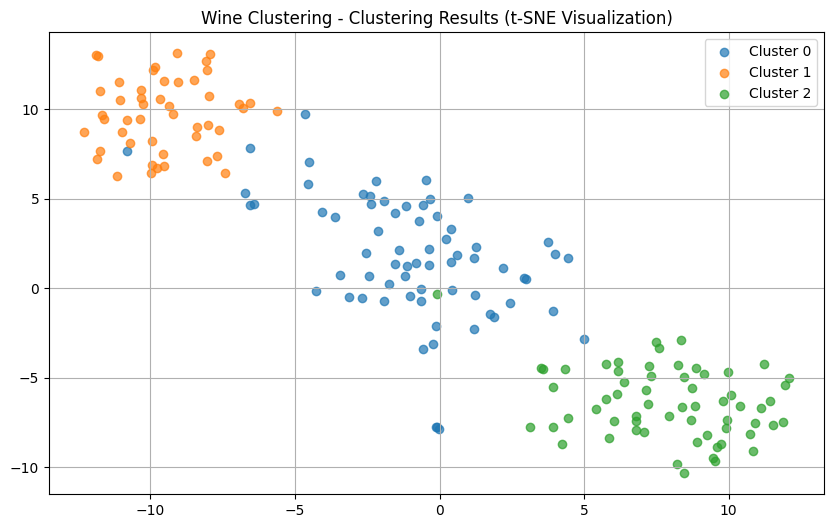

In [155]:
start_time = time.time()  # Start time

wine_labels = expectation_maximization(wine_data_scaled, k=3)

end_time = time.time()  # End time

visualize_clusters_with_tsne(wine_data_scaled, wine_labels, "Wine Clustering")

In [156]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 1.4728 seconds
Wine Dataset - Average Intra-cluster Distance: 2.5288443209469835
Wine Dataset - Average Inter-cluster Distance: 4.194094847196198


### 7.2.2. Customer dataset

Converged at iteration 44


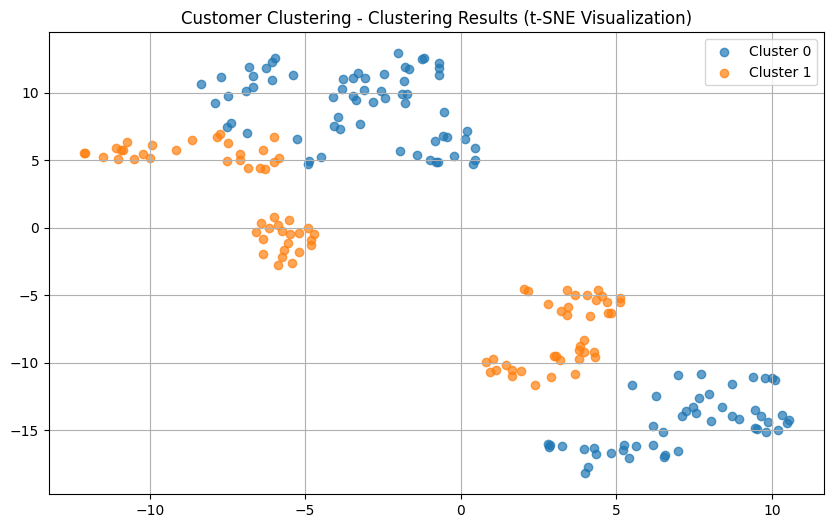

In [157]:
start_time = time.time()  # Start time

customer_labels = expectation_maximization(customer_data_scaled, k=2)

end_time = time.time()  # End time

visualize_clusters_with_tsne(customer_data_scaled, customer_labels, "Customer Clustering")

In [158]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 2.7873 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6619583714507438
Customer Dataset - Average Inter-cluster Distance: 2.0491101682167203


# 8. DBSCAN Clustering

Standardize both datasets

In [159]:
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_preprocessed)
wine_data_scaled = scaler.fit_transform(wine_data_preprocessed)

## 8.1. With libraries

### 8.1.1. Wine dataset

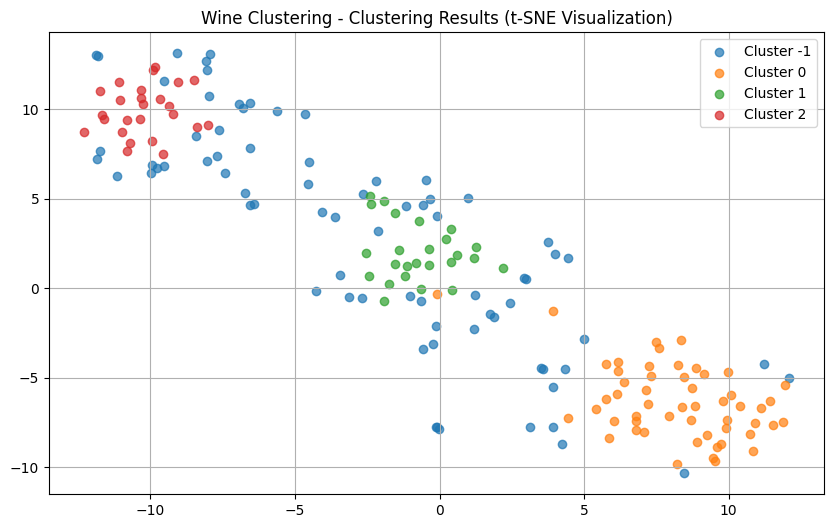

In [160]:
start_time = time.time()  # Start time

wine_db = DBSCAN(eps=2.34, min_samples=12)
wine_labels = wine_db.fit_predict(wine_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(wine_data_scaled, wine_labels, "Wine Clustering")

In [161]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 0.0067 seconds
Wine Dataset - Average Intra-cluster Distance: 4.460022309422037
Wine Dataset - Average Inter-cluster Distance: 3.687927445611518


### 8.1.2. Customer dataset

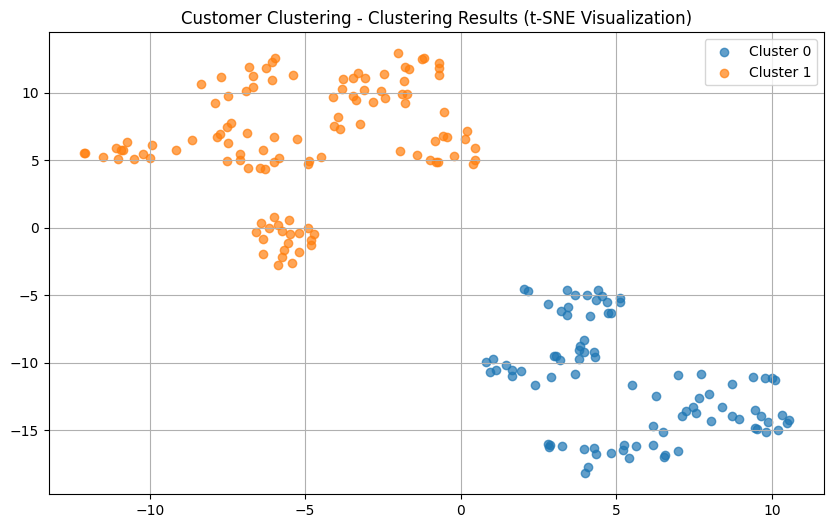

In [162]:
start_time = time.time()  # Start time

customer_db = DBSCAN(eps=1.5, min_samples=5)
customer_labels = customer_db.fit_predict(customer_data_scaled)

end_time = time.time()  # End time

# Visualize the clustering results with t-SNE
visualize_clusters_with_tsne(customer_data_scaled, customer_labels, "Customer Clustering")

In [163]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 0.0047 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6317346696989905
Customer Dataset - Average Inter-cluster Distance: 2.0248692548719602


## 8.2. Manually

### Functions


Find neighbors within epsilon

In [164]:
def find_neighbors(data, point_idx, eps):
    neighbors = []
    for i in range(len(data)):
        if np.linalg.norm(data[point_idx] - data[i]) <= eps:
            neighbors.append(i)
    return neighbors

Expand cluster

In [165]:
def expand_cluster(data, labels, point_idx, cluster_id, eps, min_pts):
    neighbors = find_neighbors(data, point_idx, eps)
    if len(neighbors) < min_pts:
        labels[point_idx] = -1  # Mark as noise
        return False

    # Mark initial point as part of the cluster
    labels[point_idx] = cluster_id

    # Process all neighbors
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        if labels[neighbor_idx] == -1:  # Change noise to border point
            labels[neighbor_idx] = cluster_id
        elif labels[neighbor_idx] == -2:  # Unvisited point
            labels[neighbor_idx] = cluster_id
            new_neighbors = find_neighbors(data, neighbor_idx, eps)
            if len(new_neighbors) >= min_pts:
                neighbors += new_neighbors  # Expand cluster
        i += 1
    return True

DBSCAN Implementation

In [166]:
def dbscan(data, eps, min_pts):
    labels = np.zeros(len(data), dtype=int) - 2  # -2: unvisited, -1: noise, cluster_id: positive integer
    cluster_id = 0

    for point_idx in range(len(data)):
        if labels[point_idx] != -2:  # Skip already visited points
            continue
        if expand_cluster(data, labels, point_idx, cluster_id, eps, min_pts):
            cluster_id += 1  # Start a new cluster

    return labels

Visualize DBSCAN Results

In [167]:
def visualize_dbscan_results(data, labels, dataset_name):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    unique_labels = np.unique(labels)
    plt.figure(figsize=(10, 6))
    for label in unique_labels:
        color = plt.cm.tab10(label / max(unique_labels))  # Assign colors to clusters
        label_name = f'Cluster {int(label)}'
        plt.scatter(tsne_data[labels == label, 0], tsne_data[labels == label, 1],
                    label=label_name, alpha=0.7)

    plt.title(f'{dataset_name} - DBSCAN Clustering Results')
    plt.legend()
    plt.grid(True)
    plt.show()

Plot k-distance graph to tune epsilon

In [168]:
def plot_k_distance_graph(data, k=5):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)

    # Sort distances for the k-th nearest neighbor
    distances = np.sort(distances[:, k-1])

    # Plot the sorted distances
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'k-Distance Graph (k={k})')
    plt.xlabel('Points Sorted by Distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.grid(True)
    plt.show()

Tune DBSCAN parameters

In [169]:
def tune_dbscan(data, eps_values, min_pts_values, dataset_name, expected_clusters=3):
    best_eps = None
    best_min_pts = None
    best_fit = []

    # Iterate through eps and min_pts combinations
    for eps in eps_values:
        for min_pts in min_pts_values:
            labels = dbscan(data, eps, min_pts)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            num_noise = list(labels).count(-1)

            if num_clusters == expected_clusters:
                data_row = {'eps': eps, 'min_pts': min_pts, 'clusters': num_clusters, 'noise': num_noise}
                best_fit.append(data_row)

            print(f"DBSCAN with eps={eps}, min_pts={min_pts}: Clusters={num_clusters}, Noise Points={num_noise}")

            # Visualize the clustering results
            visualize_dbscan_results(data, labels, f"{dataset_name} (eps={eps}, MinPts={min_pts})")

    best_fit_df = pd.DataFrame(best_fit)
    return best_fit

### 8.2.1. Wine dataset

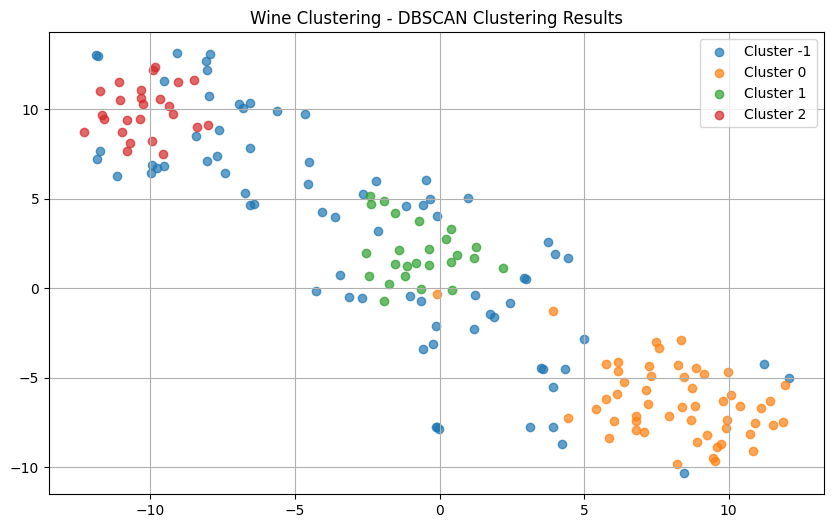

In [170]:
start_time = time.time()  # Start time

wine_labels = dbscan(wine_data_scaled, eps=2.34, min_pts=12)

end_time = time.time()  # End time

visualize_dbscan_results(wine_data_scaled, wine_labels, "Wine Clustering")

In [171]:
# Calculate metrics for Wine dataset
wine_intra = calculate_intra_cluster_distance(wine_data_scaled, wine_labels)
wine_inter = calculate_inter_cluster_distance(wine_data_scaled, wine_labels)
wine_time = end_time - start_time

print(f"Wine Dataset - Time taken for Agglomerative Clustering: {wine_time:.4f} seconds")
print(f"Wine Dataset - Average Intra-cluster Distance: {wine_intra}")
print(f"Wine Dataset - Average Inter-cluster Distance: {wine_inter}")

Wine Dataset - Time taken for Agglomerative Clustering: 0.1737 seconds
Wine Dataset - Average Intra-cluster Distance: 4.460022309422037
Wine Dataset - Average Inter-cluster Distance: 3.687927445611518


### 8.2.2. Customer dataset

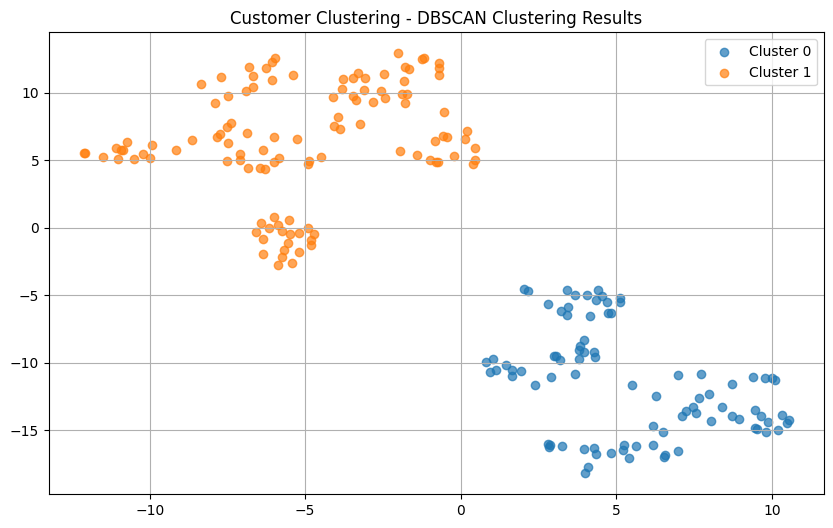

In [172]:
start_time = time.time()  # Start time

customer_labels = dbscan(customer_data_scaled, eps=1.5, min_pts=5)

end_time = time.time()  # End time

visualize_dbscan_results(customer_data_scaled, customer_labels, "Customer Clustering")

In [173]:
# Calculate metrics for Customer dataset
customer_intra = calculate_intra_cluster_distance(customer_data_scaled, customer_labels)
customer_inter = calculate_inter_cluster_distance(customer_data_scaled, customer_labels)
customer_time = end_time - start_time

print(f"Customer Dataset - Time taken for Agglomerative Clustering: {customer_time:.4f} seconds")
print(f"Customer Dataset - Average Intra-cluster Distance: {customer_intra}")
print(f"Customer Dataset - Average Inter-cluster Distance: {customer_inter}")

Customer Dataset - Time taken for Agglomerative Clustering: 0.1714 seconds
Customer Dataset - Average Intra-cluster Distance: 1.6317346696989905
Customer Dataset - Average Inter-cluster Distance: 2.0248692548719602
